# Polish Language Model Evaluation - Dataset Testing

This notebook demonstrates how to use the dataset preparation module for evaluating Polish language models. We'll explore the following aspects:

1. Loading datasets from the KLEJ benchmark
2. Exploring dataset statistics
3. Sampling datasets for evaluation
4. Preparing combined evaluation datasets

The datasets we'll be working with include:
- allegro/klej-dyk - Question-answer pairs verification
- allegro/klej-polemo2-in - Sentiment analysis for reviews
- allegro/klej-psc - Text similarity between extracts and summaries
- allegro/klej-cdsc-e - Entailment classification


## 1. Setup and Imports

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from huggingface_hub import login
from pprint import pprint

# Add the src directory to the path so we can import our modules
sys.path.append('../')
from src.datasets import PolishDatasetLoader, prepare_datasets_for_evaluation, get_dataset_examples

# Set up matplotlib styling
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Load environment variables from .env file (if it exists)
load_dotenv()

# Get Hugging Face token from environment
hf_token = os.getenv("HF_TOKEN")
if hf_token:
    # Login to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("HF_TOKEN not found in environment variables. Some datasets might not be accessible.")
    print("Create a .env file with your Hugging Face token if you encounter access issues.")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
2025-03-18 17:25:03,970 - huggingface_hub._login - WARNING - Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Successfully logged in to Hugging Face!


## 2. Initialize the Dataset Loader

In [2]:
# Create a cache directory for datasets to avoid re-downloading
cache_dir = "../data/cache"
os.makedirs(cache_dir, exist_ok=True)

# Initialize the dataset loader
loader = PolishDatasetLoader(cache_dir=cache_dir, seed=42)
print("Dataset loader initialized")

2025-03-18 17:25:05,313 - src.datasets - INFO - PolishDatasetLoader initialized with seed 42


Dataset loader initialized


## 3. Load and Explore Datasets

Let's load each dataset individually and explore its characteristics.

In [3]:
# Get information about all supported datasets
for dataset_name, info in loader.SUPPORTED_DATASETS.items():
    print(f"\n{dataset_name.upper()} - {info['description']}")
    print(f"  Path: {info['task_type']}")
    print(f"  Task type: {info['task_type']}")
    print(f"  Input columns: {', '.join(info['input_cols'])}")
    print(f"  Target column: {info['target_col']}")
    print(f"  Metrics: {', '.join(info['metrics'])}")


DYK - Question-answer pairs from Polish Wikipedia
  Path: binary_classification
  Task type: binary_classification
  Input columns: question, answer
  Target column: target
  Metrics: f1

POLEMO2 - Polish sentiment analysis for reviews
  Path: multi_classification
  Task type: multi_classification
  Input columns: sentence
  Target column: target
  Metrics: accuracy

PSC - Polish Summaries Corpus for text similarity
  Path: binary_classification
  Task type: binary_classification
  Input columns: extract_text, summary_text
  Target column: label
  Metrics: f1

CDSC - Polish sentence pairs for entailment
  Path: multi_classification
  Task type: multi_classification
  Input columns: sentence_A, sentence_B
  Target column: entailment_judgment
  Metrics: accuracy


In [4]:
# Load all datasets
datasets = loader.load_all_datasets()

# Print basic information about each dataset
for name, dataset in datasets.items():
    print(f"\n{name.upper()}:")
    for split_name, split in dataset.items():
        print(f"  {split_name} split: {len(split)} examples")

Loading datasets:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-18 17:25:09,468 - src.datasets - INFO - Loading dataset: dyk (allegro/klej-dyk)
2025-03-18 17:25:11,727 - src.datasets - INFO - Columns found in dyk: q_id, question, answer, target
2025-03-18 17:25:11,733 - src.datasets - INFO - Successfully loaded dyk
2025-03-18 17:25:11,733 - src.datasets - INFO - Loading dataset: polemo2 (allegro/klej-polemo2-in)
2025-03-18 17:25:16,064 - src.datasets - INFO - Columns found in polemo2: sentence, target
2025-03-18 17:25:16,080 - src.datasets - INFO - Successfully loaded polemo2
2025-03-18 17:25:16,081 - src.datasets - INFO - Loading dataset: psc (allegro/klej-psc)
2025-03-18 17:25:18,234 - src.datasets - INFO - Columns found in psc: extract_text, summary_text, label
2025-03-18 17:25:18,239 - src.datasets - INFO - Successfully loaded psc
2025-03-18 17:25:18,240 - src.datasets - INFO - Loading dataset: cdsc (allegro/klej-cdsc-e)
2025-03-18 17:25:20,446 - src.datasets - INFO - Columns found in cdsc: pair_ID, sentence_A, sentence_B, entailment_ju


DYK:
  train split: 4154 examples
  test split: 1029 examples

POLEMO2:
  train split: 5783 examples
  validation split: 723 examples
  test split: 722 examples

PSC:
  train split: 4302 examples
  test split: 1078 examples

CDSC:
  train split: 8000 examples
  validation split: 1000 examples
  test split: 1000 examples


## 4. Detailed Dataset Statistics

Let's get more detailed statistics for each dataset.

In [5]:
# Get statistics for each dataset
for dataset_name in loader.SUPPORTED_DATASETS.keys():
    stats = loader.get_dataset_stats(dataset_name)
    print(f"\n{stats['name'].upper()} - {stats['description']}")
    print(f"Task: {stats['task_type']}")
    
    for split_name, split_stats in stats['splits'].items():
        print(f"\n{split_name} split:")
        print(f"  Examples: {split_stats['examples']}")
        
        if 'class_distribution' in split_stats:
            print("  Class distribution:")
            for label, count in split_stats['class_distribution'].items():
                print(f"    Label {label}: {count} examples ({count/split_stats['examples']*100:.1f}%)")


DYK - Question-answer pairs from Polish Wikipedia
Task: binary_classification

train split:
  Examples: 4154
  Class distribution:
    Label 0: 3453 examples (83.1%)
    Label 1: 701 examples (16.9%)

test split:
  Examples: 1029
  Class distribution:
    Label 0: 855 examples (83.1%)
    Label 1: 174 examples (16.9%)

POLEMO2 - Polish sentiment analysis for reviews
Task: multi_classification

train split:
  Examples: 5783
  Class distribution:
    Label 2: 1568 examples (27.1%)
    Label 1: 2194 examples (37.9%)
    Label 0: 1050 examples (18.2%)
    Label 3: 971 examples (16.8%)

validation split:
  Examples: 723
  Class distribution:
    Label 1: 271 examples (37.5%)
    Label 2: 209 examples (28.9%)
    Label 3: 127 examples (17.6%)
    Label 0: 116 examples (16.0%)

test split:
  Examples: 722
  Class distribution:
    Label 1: 300 examples (41.6%)
    Label 3: 117 examples (16.2%)
    Label 2: 197 examples (27.3%)
    Label 0: 108 examples (15.0%)

PSC - Polish Summaries Corpus 

## 5. Visualize Class Distributions

Let's visualize the class distributions for each dataset.

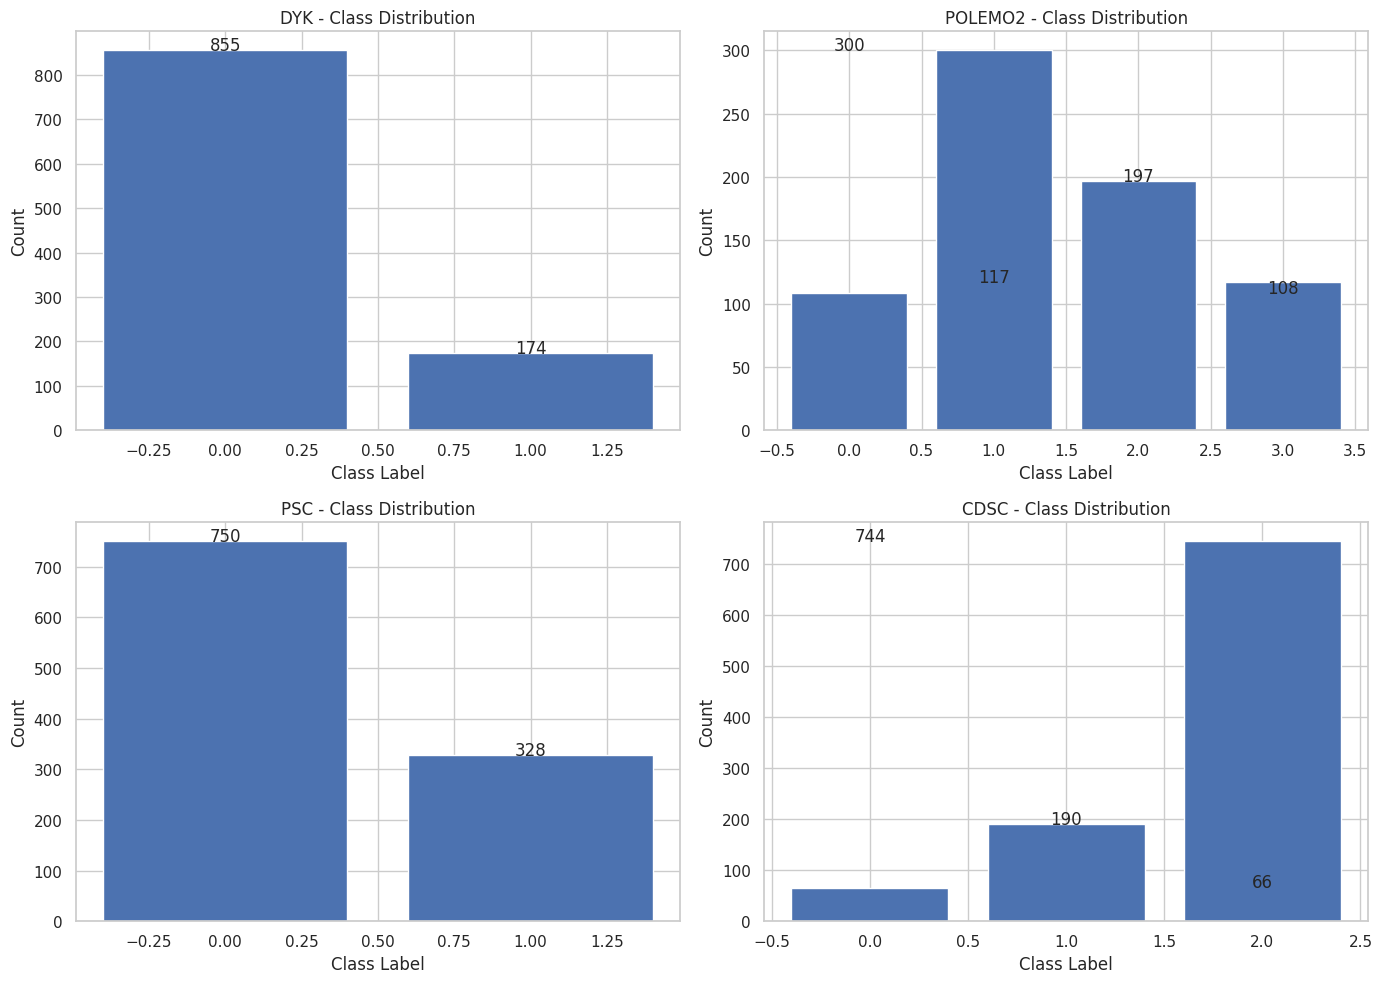

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, dataset_name in enumerate(loader.SUPPORTED_DATASETS.keys()):
    stats = loader.get_dataset_stats(dataset_name)
    
    # Use the test split for visualization
    if 'test' in stats['splits']:
        split_stats = stats['splits']['test']
    else:
        # Use the first available split if test is not available
        split_name = list(stats['splits'].keys())[0]
        split_stats = stats['splits'][split_name]
    
    if 'class_distribution' in split_stats:
        labels = list(split_stats['class_distribution'].keys())
        counts = list(split_stats['class_distribution'].values())
        
        axes[i].bar(labels, counts)
        axes[i].set_title(f"{dataset_name.upper()} - Class Distribution")
        axes[i].set_xlabel("Class Label")
        axes[i].set_ylabel("Count")
        
        # Add value labels on top of bars
        for j, count in enumerate(counts):
            axes[i].text(j, count + 0.1, str(count), ha='center')

plt.tight_layout()
plt.show()

## 6. Sample Datasets for Evaluation

Now let's see how to sample a specific number of examples from each dataset while maintaining class balance.

In [8]:
# Sample 50 examples from each dataset
samples_per_dataset = {
    'dyk': 50,
    'polemo2': 50,
    'psc': 50,
    'cdsc': 50
}

evaluation_datasets = loader.create_evaluation_dataset(
    samples_per_dataset=samples_per_dataset,
    split='test'
)

# Print information about the sampled datasets
for name, dataset in evaluation_datasets.items():
    print(f"\n{name.upper()}:")
    print(f"  Requested: {samples_per_dataset[name]} examples")
    print(f"  Sampled: {len(dataset)} examples")
    
    # Get class distribution for the sampled dataset
    info = loader.get_dataset_info(name)
    target_col = info['target_col']
    
    if 'classification' in info['task_type']:
        labels = dataset[target_col]
        
        # Count occurrences of each label
        label_counts = {}
        for label in labels:
            if label not in label_counts:
                label_counts[label] = 0
            label_counts[label] += 1
        
        print("  Class distribution in sample:")
        for label, count in label_counts.items():
            print(f"    Label {label}: {count} examples ({count/len(dataset)*100:.1f}%)")

2025-03-18 17:25:43,992 - src.datasets - INFO - Sampled 50 examples from dyk (test split)
2025-03-18 17:25:43,994 - src.datasets - INFO - Sampled 50 examples from polemo2 (test split)
2025-03-18 17:25:43,997 - src.datasets - INFO - Sampled 50 examples from psc (test split)
2025-03-18 17:25:43,998 - src.datasets - INFO - Sampled 50 examples from cdsc (test split)



DYK:
  Requested: 50 examples
  Sampled: 50 examples
  Class distribution in sample:
    Label 1: 25 examples (50.0%)
    Label 0: 25 examples (50.0%)

POLEMO2:
  Requested: 50 examples
  Sampled: 50 examples
  Class distribution in sample:
    Label 1: 13 examples (26.0%)
    Label 0: 13 examples (26.0%)
    Label 3: 12 examples (24.0%)
    Label 2: 12 examples (24.0%)

PSC:
  Requested: 50 examples
  Sampled: 50 examples
  Class distribution in sample:
    Label 1: 25 examples (50.0%)
    Label 0: 25 examples (50.0%)

CDSC:
  Requested: 50 examples
  Sampled: 50 examples
  Class distribution in sample:
    Label 1: 17 examples (34.0%)
    Label 2: 17 examples (34.0%)
    Label 0: 16 examples (32.0%)


## 7. Explore Dataset Examples

Let's look at some examples from each dataset to better understand the data.

In [9]:
for dataset_name, dataset in evaluation_datasets.items():
    info = loader.get_dataset_info(dataset_name)
    
    print(f"\n{dataset_name.upper()} EXAMPLES:")
    examples = get_dataset_examples(dataset, info, n_examples=3)
    
    for i, example in enumerate(examples):
        print(f"\nExample {i+1}:")
        for key, value in example.items():
            if isinstance(value, str) and len(value) > 100:
                # Truncate long text
                print(f"  {key}: {value[:100]}...")
            else:
                print(f"  {key}: {value}")


DYK EXAMPLES:

Example 1:
  question: w których obrazach Vincent van Gogh porzucił swobodny nastrój, charakterystyczny dla impresjonizmu?
  answer: Artysta umieścił płomienną żółcień słoneczników na znajomym, niebieskim tleOpis dotyczy wersji trzec...
  target: 1

Example 2:
  question: co ma wspólnego z kinematografią Sputnik nad Polską?
  answer: "Podczas uroczystości Dnia Niepodległości w Ambasadzie Federacji Rosyjskiej w Polsce 5. czerwca 2012...
  target: 1

Example 3:
  question: "jaka uroczystość miała miejsce 28 grudnia 1836 w dzisiejszej Adelajdzie w Australii pod ""starym eu...
  answer: The Old Gum Tree The Old Gum Tree (ang. „Stary eukaliptus”) – historyczne miejsce obecnie położone w...
  target: 1

POLEMO2 EXAMPLES:

Example 1:
  sentence: Okropnosc ! Myślę , że ludzia którzy cenią sobie własne prawa wezmą sobie ta opinie do serca . Na wł...
  target: 1

Example 2:
  sentence: Być może w ubiegłych latach było tu fajnie , ale teraz jest po prostu żle . Polozenie może i ci

## 8. Convert to DataFrame

For further analysis, it can be useful to convert datasets to Pandas DataFrames.

In [10]:
# Convert sampled datasets to pandas DataFrames
dataframes = {}

for name, dataset in evaluation_datasets.items():
    dataframes[name] = loader.dataset_to_pandas(dataset)
    
    print(f"\n{name.upper()} DataFrame:")
    print(dataframes[name].info())
    display(dataframes[name].head(2))


DYK DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   q_id      50 non-null     object
 1   question  50 non-null     object
 2   answer    50 non-null     object
 3   target    50 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 1.7+ KB
None


,q_id,question,answer,target
0,czywiesz2001,w których obrazach Vincent van Gogh porzucił s...,Artysta umieścił płomienną żółcień słonecznikó...,1
1,czywiesz164,co ma wspólnego z kinematografią Sputnik nad P...,"""Podczas uroczystości Dnia Niepodległości w Am...",1



POLEMO2 DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  50 non-null     object
 1   target    50 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 932.0+ bytes
None


,sentence,target
0,"Okropnosc ! Myślę , że ludzia którzy cenią sob...",1
1,"Być może w ubiegłych latach było tu fajnie , a...",1



PSC DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   extract_text  50 non-null     object
 1   summary_text  50 non-null     object
 2   label         50 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None


,extract_text,summary_text,label
0,Eksperci oraz przedstawiciele firm i rządów są...,Zdaniem ekspertów oraz przedstawicieli firm i ...,1
1,Decyzja rządu o zmniejszeniu Wojska Polskiego ...,Na styczeń planowana jest podwyżka cen i stawe...,0



CDSC DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   pair_ID              50 non-null     int64 
 1   sentence_A           50 non-null     object
 2   sentence_B           50 non-null     object
 3   entailment_judgment  50 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ KB
None


,pair_ID,sentence_A,sentence_B,entailment_judgment
0,3094,Chłopak w okularach patrzy na telefon komórkow...,Chłopak w okularach patrzy na telefon komórkow...,1
1,493,Kilka osób przemierza zaśnieżony teren niedale...,Cztery osoby idą po głębokim śniegu w górach .,1


## 9. Prepare Combined Dataset for Model Evaluation

Finally, let's demonstrate how to use the helper function to prepare a dataset for model evaluation.

In [11]:
# Prepare datasets for evaluation with custom sample sizes
custom_samples = {
    'dyk': 75,
    'polemo2': 100,
    'psc': 50,
    'cdsc': 75
}

eval_datasets = prepare_datasets_for_evaluation(
    samples_per_dataset=custom_samples,
    cache_dir=cache_dir,
    split='test',
    seed=42
)

print("Evaluation datasets prepared with the following sizes:")
for name, dataset in eval_datasets.items():
    print(f"  {name}: {len(dataset)} examples")

2025-03-18 17:25:52,989 - src.datasets - INFO - PolishDatasetLoader initialized with seed 42
2025-03-18 17:25:52,990 - src.datasets - INFO - Loading dataset: dyk (allegro/klej-dyk)
2025-03-18 17:25:55,103 - src.datasets - INFO - Columns found in dyk: q_id, question, answer, target
2025-03-18 17:25:55,122 - src.datasets - INFO - Successfully loaded dyk
2025-03-18 17:25:55,125 - src.datasets - INFO - Sampled 75 examples from dyk (test split)
2025-03-18 17:25:55,125 - src.datasets - INFO - Loading dataset: polemo2 (allegro/klej-polemo2-in)
2025-03-18 17:25:56,594 - src.datasets - INFO - Columns found in polemo2: sentence, target
2025-03-18 17:25:56,605 - src.datasets - INFO - Successfully loaded polemo2
2025-03-18 17:25:56,606 - src.datasets - INFO - Sampled 100 examples from polemo2 (test split)
2025-03-18 17:25:56,607 - src.datasets - INFO - Loading dataset: psc (allegro/klej-psc)
2025-03-18 17:25:58,535 - src.datasets - INFO - Columns found in psc: extract_text, summary_text, label
202

Evaluation datasets prepared with the following sizes:
  dyk: 75 examples
  polemo2: 100 examples
  psc: 50 examples
  cdsc: 75 examples


## 10. Conclusion

In this notebook, we have demonstrated how to use the dataset preparation module for Polish language model evaluation. The key functionalities include:

1. Loading datasets from the KLEJ benchmark
2. Exploring dataset statistics and class distributions
3. Sampling balanced datasets with a configurable number of examples
4. Converting datasets to pandas DataFrames for further analysis
5. Preparing combined evaluation datasets

These evaluation datasets can now be used to evaluate the performance of different Polish language models as specified in the project requirements.